In [1]:
from matplotlib import pyplot as plt
from L500analysis.plotting.tools.figure_formatting import MyLogFormatter
%matplotlib inline

We first plot the pressure profiles from the stacked McDonald+14 Chandra data at $<z>=0.4$ and $<z>=0.8$.

In [2]:
import numpy as np
from SZmaps.utils.obs_utils import general_nfw_profile, McDonald14_params

rbins = np.arange(.1,5.,0.01)
def plot_McDonald(rbins) :
    plt.plot(rbins, general_nfw_profile(rbins,**McDonald14_params['z=0.4']),ls=':',label='M14: z=0.4')
    plt.plot(rbins, general_nfw_profile(rbins,**McDonald14_params['z=0.8']),ls=':',label='M14: z=0.8')
    plt.xscale('log')
    plt.yscale('log')
    plt.ylabel('$\\tilde{P}$',fontsize='xx-large')
    plt.xlabel('r/R$_{500c}$',fontsize='xx-large')
    plt.legend()
    plt.gca().xaxis.set_major_formatter(MyLogFormatter())
    plt.gca().yaxis.set_major_formatter(MyLogFormatter())

Now we compare with the L500 NR, CSF, and AGN average pressure profiles with different averaged weighting

In [65]:
import numpy as np

def calculate_scaled_profile(aexp, r_mid, r500c, profile, M500c, rbins=rbins)  :
    radii_scaled_by_500c = r_mid / r500c
    pressure_scaled_by_500c = calculate_scaled_pressure(profile, aexp, M500c)
    profile_scaled_by_500c = np.interp(rbins, 
                                       radii_scaled_by_500c, 
                                       pressure_scaled_by_500c)
    assert(profile_scaled_by_500c.shape == rbins.shape)
    return profile_scaled_by_500c
    
def calculate_scaled_pressure(pressure_profile, aexp, M500c) :
    return pressure_profile / calculate_P500(M500c,aexp)

def calculate_P500(M500c, aexp) :
    from astropy.cosmology import WMAP9 as cosmo
    '''Returns P500 in erg/cm**3. M500c expected in Msun/h'''
    return 1.45*1e-11 * (M500c / 1e15)**(2./3) * cosmo.efunc(1./float(aexp) - 1.)

def test_calculate_P500() :
    aexp = 1.
    m500c = 1e15
    assert(calculate_P500(1e15, aexp) == 1.45*1e-11)

def test_calculate_scaled_pressure() :
    import numpy as np
    flat_pressure_profile = np.zeros(100)+1.
    aexp =1.
    #print calculate_scaled_pressure(flat_pressure_profile, aexp, 1e15)
    assert(np.all(calculate_scaled_pressure(flat_pressure_profile, aexp, 1e15) == 1/(1.45*1e-11)))

def test_calculate_scaled_profile() :
    import numpy as np
    aexp = 1.
    r_mid = np.arange(0.0, 10,.1)
    r500c = 500.
    profile = np.zeros(100)+1.
    M500c = 1e15
    assert(np.all(calculate_scaled_profile(aexp,r_mid, r500c, profile, M500c,rbins=rbins[:len(r_mid)])\
                  == np.zeros(100)+1./(1.45*1e-11) ) )
    
test_calculate_P500()
test_calculate_scaled_pressure()
test_calculate_scaled_profile()

# Normalization function collections
def pressure_critical_density_evolution(aexp) :
    '''Returns E(z)**(2/3)'''
    from astropy.cosmology import WMAP9 as cosmo
    return cosmo.efunc( 1./float(aexp) - 1. )

def calculate_average_normalized_profiles(halo_profiles_dict, halo_properties_dict, halo_ids, profile_name, evolution_normalization_function=None, M500min=1e13) :
    '''evolution_normalization_function should be from normalization_collections'''
    from collections import defaultdict
    average_profiles = defaultdict(list)
    for aexp in halo_profiles_dict.keys() :
        halo_profiles_dataframe = halo_profiles_dict[aexp]
        halo_properties_dataframe = halo_properties_dict[aexp]
        for halo_id in halo_ids[aexp] :
            halo_id_profile_dataframe = halo_profiles_dataframe[halo_profiles_dataframe['id']==halo_id]
            halo_id_property_dataframe = halo_properties_dataframe[halo_properties_dataframe['id']==halo_id]
            r_mid = halo_id_profile_dataframe.as_matrix(columns=['r_mid'])[:,0]
            profile = halo_id_profile_dataframe.as_matrix(columns=[profile_name])[:,0]
            r500c = halo_id_property_dataframe.as_matrix(columns=['r500c'])[:,0]
            M500c = halo_id_property_dataframe.as_matrix(columns=['M_total_500c'])[:,0]
            if M500c < M500min :
                continue
            average_profiles[aexp].append(calculate_scaled_profile(aexp, r_mid, r500c, profile, M500c, rbins=rbins))
        
        average_profiles[aexp] = np.array(average_profiles[aexp]).mean(axis=0)
    return average_profiles

In [66]:
M500min=3e14
nr_avg_profiles = get_simulation_average_profiles(database_name='L500_NR_0',M500min=M500min)
csf_avg_profiles = get_simulation_average_profiles(database_name='L500_CSF_0',M500min=M500min)
agn_avg_profiles = get_simulation_average_profiles(database_name='L500_AGN_0',M500min=M500min)


looking in /home/babyostrich/data/databases/ for L500_NR_0.db
looking in /home/babyostrich/data/databases/ for L500_CSF_0.db
looking in /home/babyostrich/data/databases/ for L500_AGN_0.db


Plotting some simulation profiles.  Overall, what we see is that the simulations have higher normalization than the McDonald+14 profiles.  However, there is an analogous trend with redshift.  The high redshift bin has a higher normalized pressure in the inner regions.  As the scaled radius increase, the profiles cross over, and the high redshift bin has lower pressure. Note: this trend does not hold if we allow low mass halos in the sample.

In [6]:
def plot_sim_pressure_w_McDonald(avg_profiles, Pkey=None) :
    for aexp in avg_profiles[Pkey].keys() :
        plt.plot(rbins, avg_profiles[Pkey][aexp],ls='-.',label=Pkey+': z=%.1f'%(1./aexp-1.))
    plot_McDonald(rbins)    

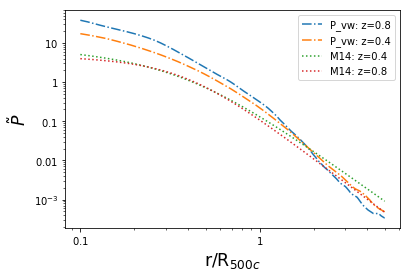

In [37]:
# Velocity weighted pressure
plot_sim_pressure_w_McDonald(nr_avg_profiles, Pkey = 'P_vw')
plt.savefig('P_vw_nr')

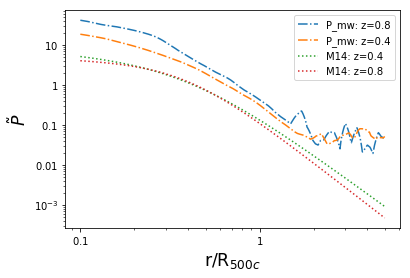

In [38]:
# Mass weighted pressure
plot_sim_pressure_w_McDonald(nr_avg_profiles, Pkey = 'P_mw')
plt.savefig('P_mw_nr')

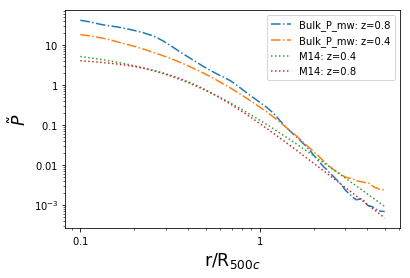

In [39]:
# Mass weighted bulk pressure
plot_sim_pressure_w_McDonald(nr_avg_profiles, Pkey = 'Bulk_P_mw')
plt.savefig('Bulk_P_mw_nr')

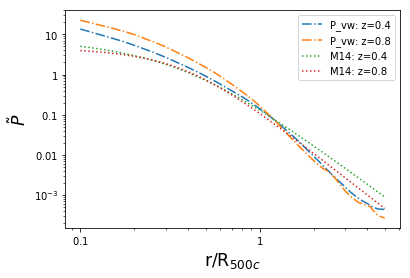

In [40]:
# Velocity weighted pressure
plot_sim_pressure_w_McDonald(csf_avg_profiles, Pkey = 'P_vw')
plt.savefig('P_vw_csf')

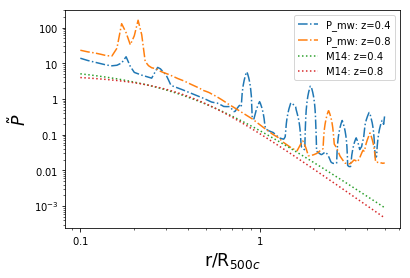

In [41]:
# Mass weighted pressure
plot_sim_pressure_w_McDonald(csf_avg_profiles, Pkey = 'P_mw')
plt.savefig('P_mw_csf')

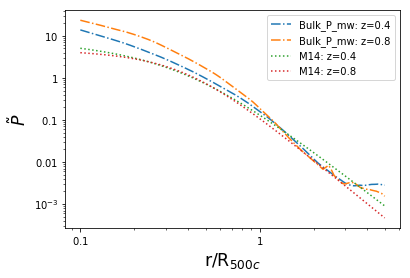

In [42]:
# Mass weighted bulk pressure
plot_sim_pressure_w_McDonald(csf_avg_profiles, Pkey = 'Bulk_P_mw')
plt.savefig('Bulk_P_mw_csf')

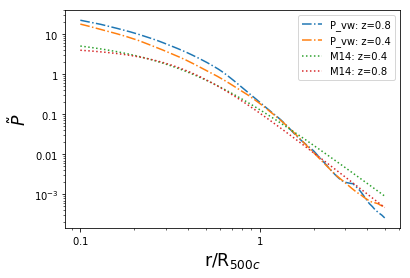

In [43]:
# Velocity weighted pressure
plot_sim_pressure_w_McDonald(agn_avg_profiles, Pkey = 'P_vw')
plt.savefig('P_vw_agn')

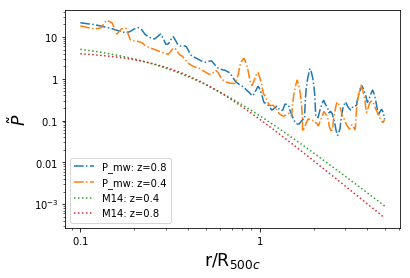

In [44]:
# Mass weighted pressure
plot_sim_pressure_w_McDonald(agn_avg_profiles, Pkey = 'P_mw')
plt.savefig('P_mw_agn')

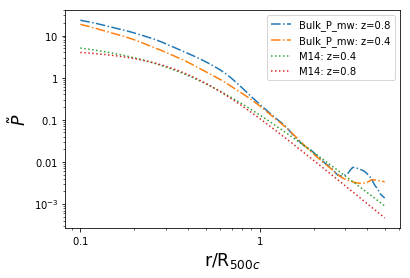

In [45]:
# Mass weighted bulk pressure
plot_sim_pressure_w_McDonald(agn_avg_profiles, Pkey = 'Bulk_P_mw')
plt.savefig('Bulk_P_mw_agn')

The same allowing low mass halos into the sample.

In [ ]:
M500min=1e13
nr_avg_profiles = get_simulation_average_profiles(database_name='L500_NR_0',M500min=M500min)
csf_avg_profiles = get_simulation_average_profiles(database_name='L500_CSF_0',M500min=M500min)
agn_avg_profiles = get_simulation_average_profiles(database_name='L500_AGN_0',M500min=M500min)


looking in /home/babyostrich/data/databases/ for L500_NR_0.db
looking in /home/babyostrich/data/databases/ for L500_CSF_0.db
looking in /home/babyostrich/data/databases/ for L500_AGN_0.db


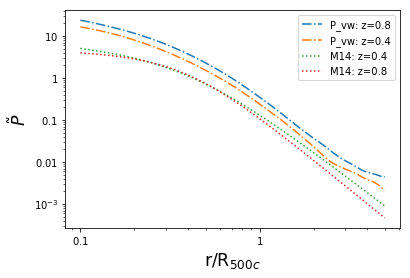

In [47]:
# Velocity weighted pressure
plot_sim_pressure_w_McDonald(nr_avg_profiles, Pkey = 'P_vw')
plt.savefig('P_vw_nr_all_halos')

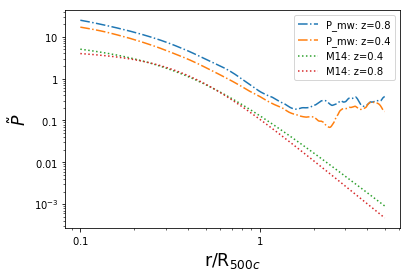

In [48]:
# Mass weighted pressure
plot_sim_pressure_w_McDonald(nr_avg_profiles, Pkey = 'P_mw')
plt.savefig('P_mw_nr_all_halos')

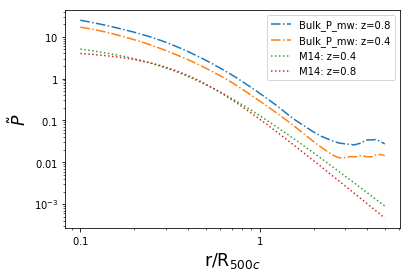

In [49]:
# Mass weighted bulk pressure
plot_sim_pressure_w_McDonald(nr_avg_profiles, Pkey = 'Bulk_P_mw')
plt.savefig('Bulk_P_mw_nr_all_halos')

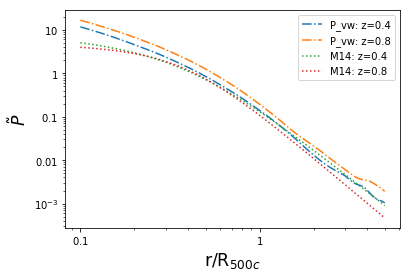

In [62]:
# Velocity weighted pressure
plot_sim_pressure_w_McDonald(csf_avg_profiles, Pkey = 'P_vw')
plt.savefig('P_vw_csf_all_halos')

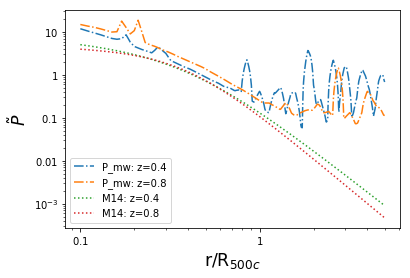

In [63]:
# Mass weighted pressure
plot_sim_pressure_w_McDonald(csf_avg_profiles, Pkey = 'P_mw')
plt.savefig('P_mw_csf_all_halos')

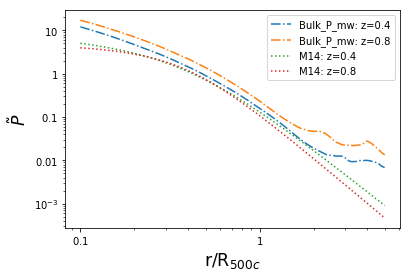

In [64]:
# Mass weighted bulk pressure
plot_sim_pressure_w_McDonald(csf_avg_profiles, Pkey = 'Bulk_P_mw')
plt.savefig('Bulk_P_mw_csf_all_halos')

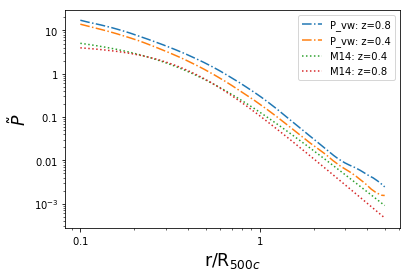

In [59]:
# Velocity weighted pressure
plot_sim_pressure_w_McDonald(agn_avg_profiles, Pkey = 'P_vw')
plt.savefig('P_vw_agn_all_halos')

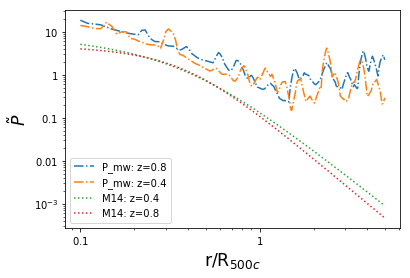

In [60]:
# Mass weighted pressure
plot_sim_pressure_w_McDonald(agn_avg_profiles, Pkey = 'P_mw')
plt.savefig('P_mw_agn_all_halos')

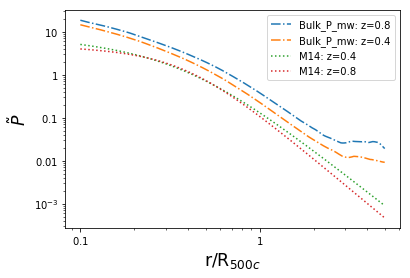

In [61]:
# Mass weighted bulk pressure
plot_sim_pressure_w_McDonald(agn_avg_profiles, Pkey = 'Bulk_P_mw')
plt.savefig('Bulk_P_mw_agn_all_halos')